In [27]:
import pandas as pd 
import numpy as np 
import math as m 
from matplotlib import pyplot as plt 
from scipy.stats import norm 
import random
#get all the colors in colors
from matplotlib import colors as mcolors
colors=[]
for i in mcolors.CSS4_COLORS: colors.append(i)

In [294]:
#instantiate variables
_num_steps = 10000
_timeInc = 1e-9 # (s)
_radius = 105 # (nm)
_height = 500 # (nm)
_NPdensity = 1.05e-21 # density of polysterene (g/nm^3)
_viscosity = 1e-9 # viscosity of water (kg/um/s)
_thermal = 4.11 #scaled temperature Kb*T (nm^2*g/s^2)
#Without External Forces!!!!
acc = 0
volume = (4.0 / 3.0) * np.pi * _radius**3 #(nm^3)
mass = _NPdensity * volume * 1.0e9 # volume of NP (nm^3)
beta_old = (3.0 * np.pi * _viscosity * (_radius * 2.0 * 0.001))/ (mass*1e-12) # see {English, Biophys.J, 2014} (s^-1)

# for _height >> _radius, Beta and Beta_rot
_drag_coeff_trans = {'x&y translation':(4*np.pi*_viscosity*_height)/(np.log(_height/2*_radius)+.84),'z translation':(2*np.pi*_viscosity*_height)/(np.log(_height/2*_radius)-.2)}
_drag_coeff_ang = {'long axis rotation':(np.pi*_viscosity*_height**3)/(3*(np.log(_height/2*_radius)-.66)),'short axis rotation':4*np.pi*_viscosity*_radius**2*_height}

#function that tells you how much drag the rod is experiencing in each direction 
#for translation
def fraction_of_drag_coeff_trans(velocity):
    x_and_y_fraction = float((velocity['v_x'].iloc[-1]**2 + velocity['v_y'].iloc[-1]**2) / (velocity['v_x'].iloc[-1]**2 + velocity['v_y'].iloc[-1]**2 + velocity['v_z'].iloc[-1]**2))
    z_fraction = float(velocity['v_z'].iloc[-1]**2 / (velocity['v_x'].iloc[-1]**2 + velocity['v_y'].iloc[-1]**2 + velocity['v_z'].iloc[-1]**2))
    return({'x&y translation':x_and_y_fraction,'z translation':z_fraction})
#for rotation
def fraction_of_drag_coeff_ang(angular_velocity):
    long_axis_fraction = float((angular_velocity['w_x'].iloc[-1]**2 + angular_velocity['w_y'].iloc[-1]**2) / (angular_velocity['w_x'].iloc[-1]**2 + angular_velocity['w_y'].iloc[-1]**2 + angular_velocity['w_z'].iloc[-1]**2))
    short_axis_fraction = float(angular_velocity['w_z'].iloc[-1]**2 / (angular_velocity['w_x'].iloc[-1]**2 + angular_velocity['w_y'].iloc[-1]**2 + angular_velocity['w_z'].iloc[-1]**2))
    return({'long axis rotation':long_axis_fraction,'short axis rotation':short_axis_fraction})

#translational coefficients
def trans_coeff(velocity):
    beta = (fraction_of_drag_coeff_trans(velocity)['x&y translation'] *_drag_coeff_trans['x&y translation']+fraction_of_drag_coeff_trans(velocity)['z translation'] *_drag_coeff_trans['z translation'])
    dev1 = np.exp(-2.0 * beta * _timeInc)
    dev2 = (3.0 - 4.0*np.exp(-beta * _timeInc))
    dev3 = abs(2 - (dev1 + dev2) / (beta * _timeInc)) # the minus sign here gives a negative value. I'm taking the abs for now. 
    stddev_pos = np.sqrt(_timeInc * _timeInc * _thermal / (mass * 1e-9) / beta / _timeInc * dev3)
    stddev_vel = np.sqrt(_thermal / (mass * 1e-9) * (1.0 - np.exp(-2.0 * beta * _timeInc)))# (nm/s)
    cor = _thermal / (mass * 1e-9) / beta * (1 - np.exp(-beta * _timeInc)) * (1 - np.exp(-beta * _timeInc)) / stddev_pos / stddev_vel # (dimensionless)
    v_coeff1 = stddev_vel * cor
    v_coeff2 = stddev_vel * np.sqrt(1 - cor * cor)
    c0 = np.exp(-1.0 * beta * _timeInc) # (dimensionless)
    c1 = (1.0 - c0) / (beta * _timeInc) # (dimensionless)
    c2 = (1.0 - c1) / (beta * _timeInc) # (dimensionless)
    a = c1 * _timeInc
    b = c2 * _timeInc * _timeInc * 1e9
    c = a * 1e9
    return({'c0':c0,'a':a,'b':b,'c':c,'stddev_pos':stddev_pos,'v_coeff1':v_coeff1,'v_coeff2':v_coeff2})

def ang_coeff(angular_velocity):
    beta = (fraction_of_drag_coeff_ang(angular_velocity)['long axis rotation'] *_drag_coeff_ang['long axis rotation'] +fraction_of_drag_coeff_ang(angular_velocity)['short axis rotation'] *_drag_coeff_ang['short axis rotation'])
    dev1 = np.exp(-2.0 * beta * _timeInc)
    dev2 = (3.0 - 4.0*np.exp(-beta * _timeInc))
    dev3 = abs(2 - (dev1 + dev2) / (beta * _timeInc)) # the minus sign here gives a negative value. I'm taking the abs for now. 
    stddev_pos = np.sqrt(_timeInc * _timeInc * _thermal / (mass * 1e-9) / beta / _timeInc * dev3)
    stddev_vel = np.sqrt(_thermal / (mass * 1e-9) * (1.0 - np.exp(-2.0 * beta * _timeInc)))# (nm/s)
    cor = _thermal / (mass * 1e-9) / beta * (1 - np.exp(-beta * _timeInc)) * (1 - np.exp(-beta * _timeInc)) / stddev_pos / stddev_vel # (dimensionless)
    v_coeff1 = stddev_vel * cor
    v_coeff2 = stddev_vel * np.sqrt(1 - cor * cor)
    c0 = np.exp(-1.0 * beta * _timeInc) # (dimensionless)
    c1 = (1.0 - c0) / (beta * _timeInc) # (dimensionless)
    c2 = (1.0 - c1) / (beta * _timeInc) # (dimensionless)
    a = c1 * _timeInc
    b = c2 * _timeInc * _timeInc * 1e9
    c = a * 1e9
    return({'c0':c0,'a':a,'b':b,'c':c,'stddev_pos':stddev_pos,'v_coeff1':v_coeff1,'v_coeff2':v_coeff2})

position = pd.DataFrame({'x':[0],'y':[0],'z':[0]})
velocity = pd.DataFrame({'v_x':[0.01],'v_y':[0],'v_z':[0]})
angular_postion = pd.DataFrame({'theta_x':[0],'theta_y':[0],'theta_z':[0]})
angular_velocity = pd.DataFrame({'w_x':[0.01],'w_y':[0],'w_z':[0]})
#Define Functions:
def box_muller_transform():
  s=0
  while (s > 1 or s == 0):
    u=random.uniform(-1,1)
    v=random.uniform(-1,1)
    s=u**2+v**2
  sqrt =np.sqrt(-2.0*np.log(s)/s)
  rand_pos = u*sqrt
  rand_vel = v*sqrt
  return{'random position':rand_pos,'random velocity':rand_vel}

def random_nums():
  import random
  ran=np.array([])
  for i in range(0,1000):
    ran=np.append(ran,random.uniform(-1,1))
  return(ran)

def keep_theta_in_domain(theta):
    if theta>(2*np.pi):
        mult = m.ceil(theta/(2*np.pi))
        theta-=mult*2*np.pi
        theta = abs(theta)
    elif theta<0:
        theta = abs(theta)
        mult = m.ceil(theta/(2*np.pi))
        theta-=mult*2*np.pi
        theta = abs(a)
    
    return(theta)

#Without External Forces!!!!
def translation(position,velocity,index):
    ran_pos = {'x':box_muller_transform()['random position'],'y':box_muller_transform()['random position'], 'z':box_muller_transform()['random position']}
    ran_vel = {'v_x':box_muller_transform()['random velocity'],'v_y':box_muller_transform()['random velocity'], 'v_z':box_muller_transform()['random velocity']}
    
    x = [position['x'].iloc[-1] + trans_coeff(velocity)['a'] * velocity['v_x'].iloc[-1] + trans_coeff(velocity)['b'] * acc + ran_pos['x'] * trans_coeff(velocity)['stddev_pos']]
    y = [position['y'].iloc[-1] + trans_coeff(velocity)['a'] * velocity['v_y'].iloc[-1] + trans_coeff(velocity)['b'] * acc + ran_pos['y'] * trans_coeff(velocity)['stddev_pos']]
    z = [position['z'].iloc[-1] + trans_coeff(velocity)['a'] * velocity['v_z'].iloc[-1] + trans_coeff(velocity)['b'] * acc + ran_pos['z'] * trans_coeff(velocity)['stddev_pos']]
    new_pos = pd.DataFrame({'x':x,'y':y,'z':z},index = [index])
    position = position.append(new_pos)

    v_x = [trans_coeff(velocity)['c0'] * velocity['v_x'].iloc[-1]+ trans_coeff(velocity)['c'] * acc + trans_coeff(velocity)['v_coeff1'] * ran_pos['x'] + trans_coeff(velocity)['v_coeff2'] * ran_vel['v_x']]
    v_y = [trans_coeff(velocity)['c0'] * velocity['v_y'].iloc[-1]+ trans_coeff(velocity)['c'] * acc + trans_coeff(velocity)['v_coeff1'] * ran_pos['y'] + trans_coeff(velocity)['v_coeff2'] * ran_vel['v_y']]
    v_z = [trans_coeff(velocity)['c0'] * velocity['v_z'].iloc[-1]+ trans_coeff(velocity)['c'] * acc + trans_coeff(velocity)['v_coeff1'] * ran_pos['z'] + trans_coeff(velocity)['v_coeff2'] * ran_vel['v_z']]
    new_vel = pd.DataFrame({'v_x':v_x,'v_y':v_y,'v_z':v_z},index = [index])
    velocity = velocity.append(new_vel)
    return (position,velocity)

def rotation(theta,w,index):
    ran_theta = {'theta_x':box_muller_transform()['random position'],'theta_y':box_muller_transform()['random position'], 'theta_z':box_muller_transform()['random position']}
    ran_w = {'w_x':box_muller_transform()['random velocity'],'w_y':box_muller_transform()['random velocity'], 'w_z':box_muller_transform()['random velocity']}
    
    theta_x = [theta['theta_x'].iloc[-1] + ang_coeff(angular_velocity)['a'] * angular_velocity['w_x'].iloc[-1] + ang_coeff(angular_velocity)['b'] * acc + ran_theta['theta_x'] * ang_coeff(angular_velocity)['stddev_pos']]
    theta_y = [theta['theta_y'].iloc[-1] + ang_coeff(angular_velocity)['a'] * angular_velocity['w_y'].iloc[-1] + ang_coeff(angular_velocity)['b'] * acc + ran_theta['theta_y'] * ang_coeff(angular_velocity)['stddev_pos']]
    theta_z = [theta['theta_z'].iloc[-1] + ang_coeff(angular_velocity)['a'] * angular_velocity['w_z'].iloc[-1] + ang_coeff(angular_velocity)['b'] * acc + ran_theta['theta_z'] * ang_coeff(angular_velocity)['stddev_pos']]
    theta_x[0] = keep_theta_in_domain(theta_x[0])
    theta_y[0] = keep_theta_in_domain(theta_y[0])
    theta_z[0] = keep_theta_in_domain(theta_z[0])
    new_theta = pd.DataFrame({'theta_x':theta_x,'theta_y':theta_y,'theta_z':theta_z},index = [index])
    theta = theta.append(new_theta)

    w_x = [ang_coeff(angular_velocity)['c0'] * angular_velocity['w_x'].iloc[-1]+ ang_coeff(angular_velocity)['c'] * acc + ang_coeff(angular_velocity)['v_coeff1'] * ran_theta['theta_x'] + ang_coeff(angular_velocity)['v_coeff2'] * ran_w['w_x']]
    w_y = [ang_coeff(angular_velocity)['c0'] * angular_velocity['w_y'].iloc[-1]+ ang_coeff(angular_velocity)['c'] * acc + ang_coeff(angular_velocity)['v_coeff1'] * ran_theta['theta_y'] + ang_coeff(angular_velocity)['v_coeff2'] * ran_w['w_y']]
    w_z = [ang_coeff(angular_velocity)['c0'] * angular_velocity['w_z'].iloc[-1]+ ang_coeff(angular_velocity)['c'] * acc + ang_coeff(angular_velocity)['v_coeff1'] * ran_theta['theta_z'] + ang_coeff(angular_velocity)['v_coeff2'] * ran_w['w_z']]
    new_w = pd.DataFrame({'w_x':w_x,'w_y':w_y,'w_z':w_z},index = [index])
    w = w.append(new_w)
    return(theta,w)

In [254]:
# display(*translation(position,velocity))
position = pd.DataFrame({'x':[0],'y':[0],'z':[0]})
velocity = pd.DataFrame({'v_x':[0.01],'v_y':[0],'v_z':[0]})
for index in range(0,_num_steps):
    position,velocity = translation(position,velocity,index)
print('_num_steps = ', _num_steps)

_num_steps =  10000


Text(0.5, 1.0, 'velocity[v_z]')

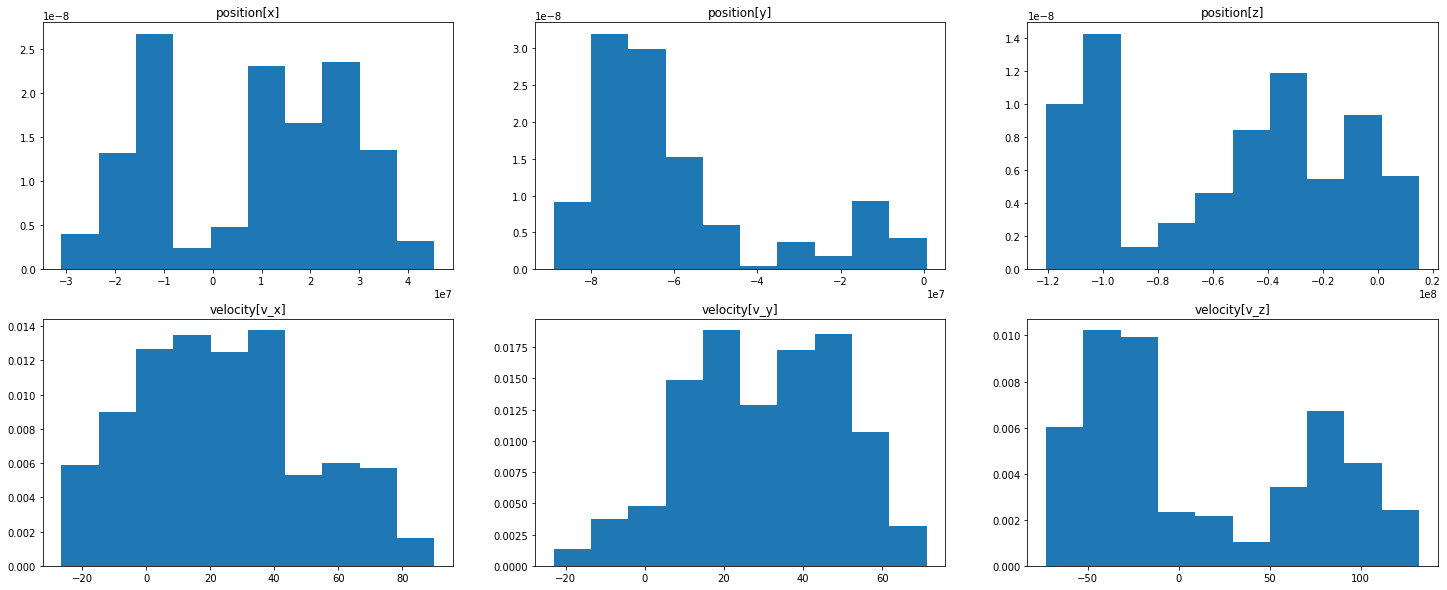

In [255]:
fig, ax = plt.subplots(2,3,figsize = (25,10))
ax[0][0].hist(position['x'],density = True)
ax[0][1].hist(position['y'],density = True)
ax[0][2].hist(position['z'],density = True)
ax[1][0].hist(velocity['v_x'],density = True)
ax[1][1].hist(velocity['v_y'],density = True)
ax[1][2].hist(velocity['v_z'],density = True)

ax[0][0].set_title('position[x]')
ax[0][1].set_title('position[y]')
ax[0][2].set_title('position[z]')
ax[1][0].set_title('velocity[v_x]')
ax[1][1].set_title('velocity[v_y]')
ax[1][2].set_title('velocity[v_z]')

In [295]:
theta = pd.DataFrame({'theta_x':[0],'theta_y':[0],'theta_z':[0]})
w = pd.DataFrame({'w_x':[0.01],'w_y':[0],'w_z':[0]})
for index in range(0,_num_steps):
    theta,w = rotation(theta,w,index)
print('_num_steps = ', _num_steps)

_num_steps =  10000


Text(0.5, 1.0, 'w[w_z]')

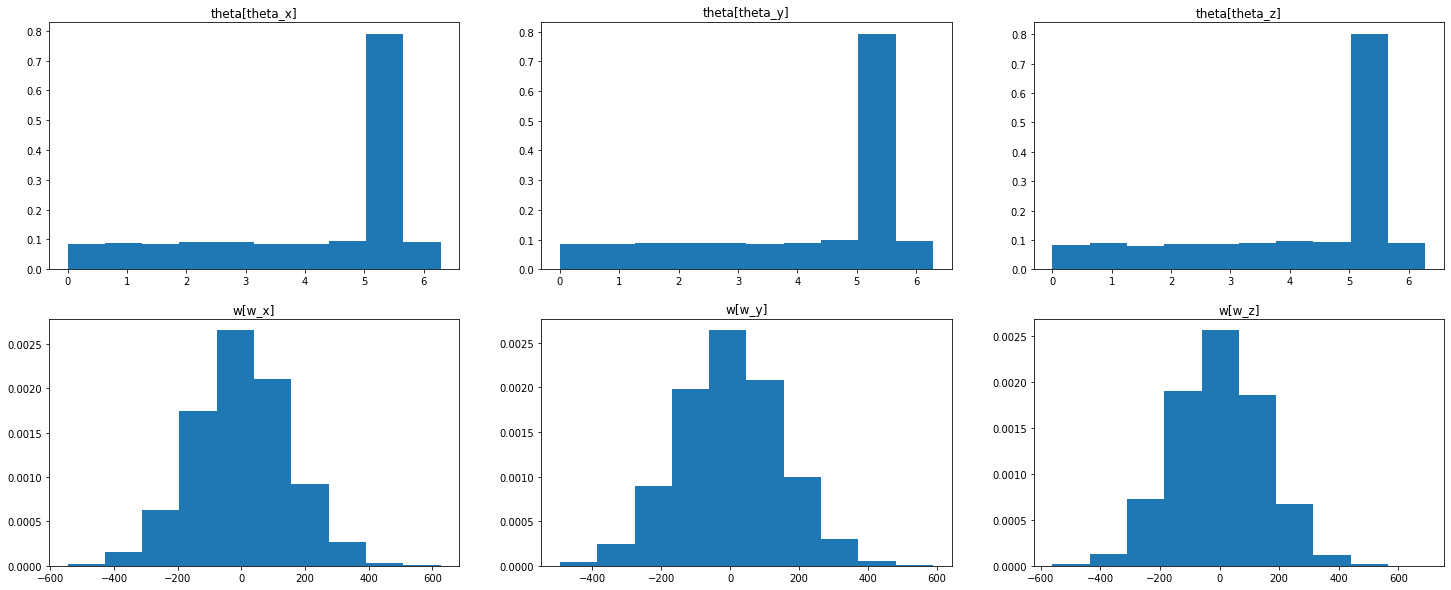

In [296]:
fig, ax = plt.subplots(2,3,figsize = (25,10))
ax[0][0].hist(theta['theta_x'],density = True)
ax[0][1].hist(theta['theta_y'],density = True)
ax[0][2].hist(theta['theta_z'],density = True)
ax[1][0].hist(w['w_x'],density = True)
ax[1][1].hist(w['w_y'],density = True)
ax[1][2].hist(w['w_z'],density = True)

ax[0][0].set_title('theta[theta_x]')
ax[0][1].set_title('theta[theta_y]')
ax[0][2].set_title('theta[theta_z]')
ax[1][0].set_title('w[w_x]')
ax[1][1].set_title('w[w_y]')
ax[1][2].set_title('w[w_z]')

In [297]:
display(theta)

,theta_x,theta_y,theta_z
0,0.000000,0.000000,0.000000
0,4.990284,5.309649,5.309649
1,3.509382,5.309649,2.306313
2,4.218776,3.968366,2.562538
3,0.927580,3.016604,3.629618
...,...,...,...
9995,5.309649,5.309649,4.950070
9996,2.083562,1.680304,5.309649
9997,5.309649,5.309649,5.309649
9998,3.018055,5.473793,1.981231


In [238]:
a = pd.DataFrame({'a':[1],'b':[4],'c':[7]},index = [3])
b = pd.DataFrame({'a':[10,11,12],'b':[13,14,15],'c':[16,17,18]})
b = b.append(a)
print(b)

    a   b   c
0  10  13  16
1  11  14  17
2  12  15  18
3   1   4   7


5.309649148733797


In [277]:
int(7/5)

1